In [1]:
import os
import csv
import numpy as np
import pandas as pd
from sklearn import linear_model, metrics
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
import copy

In [2]:
from scipy import interpolate

In [3]:
from prettytable import PrettyTable

In [4]:
# Changing Directory
os.chdir("D:\dataset")


## Train set

In [5]:
# Reading Data
df = pd.read_csv('train.csv')
df.head()

,click,weekday,hour,bidid,logtype,userid,useragent,IP,region,city,...,slotheight,slotvisibility,slotformat,slotprice,creative,bidprice,payprice,keypage,advertiser,usertag
0,0,1,14,fdfae6789b787899f1b875de3ab8b21a,1,u_Vh1OPkFv3q5CFdR,windows_ie,180.107.112.*,80,85,...,60,1,0,5,612599432d200b093719dd1f372f7a30,300,54,bebefa5efe83beee17a3d245e7c5085b,1458,"13866,10063"
1,0,2,20,372883147cdefbc495fb5082f79dde9b,1,u_VhkRL6dCOTLsq-c,windows_chrome,125.120.199.*,94,95,...,250,1,0,5,8dff45ed862a740986dbe688aafee7e5,249,42,15b749127478946f161a54dc0dad27c8,3476,"10063,10111"
2,0,5,9,2912cb5947e1fad450e2473c2f61ef75,1,u_VhkyORMrD8TP3GL,windows_ie,120.196.64.*,216,217,...,280,0,1,0,77819d3e0b3467fe5c7b16d68ad923a1,300,76,bebefa5efe83beee17a3d245e7c5085b,1458,10063
3,0,2,20,d7b7d61d1e50e1d27d210928d28a9b61,1,u_VhkyLRqVL2a4eWL,windows_ie,219.131.122.*,216,221,...,90,0,0,162,7184c9560e68e977187e67e45a4f3198,238,182,0f951a030abdaedd733ee8d114ce2944,3427,"10077,10111"
4,0,6,9,657d317dc4045bb79c2652abbea07530,1,u_Vh1zOJuQOtTCBgL,windows_chrome,123.190.78.*,40,48,...,90,0,1,0,c938195f9e404b4f38c7e71bf50263e5,238,34,a3becb967c015e9acb5e72f22b100ef8,3476,"10031,13042,10006,10057,13866,10063,14273,1005..."


## Selecting Wanted Features

In [6]:
# Define our features
features = ["click", "weekday", "hour", "region", "slotwidth", 'slotheight', 'useragent', 'payprice', 'bidprice']
df = df[features]
df = df.dropna()

In [7]:
df['slotsize'] = df['slotwidth'] * df['slotheight'] 
df.drop(['slotwidth', 'slotheight'], axis=1, inplace=True)

In [8]:
df.head()

,click,weekday,hour,region,useragent,payprice,bidprice,slotsize
0,0,1,14,80,windows_ie,54,300,28080
1,0,2,20,94,windows_chrome,42,249,62500
2,0,5,9,216,windows_ie,76,300,94080
3,0,2,20,216,windows_ie,182,238,65520
4,0,6,9,40,windows_chrome,34,238,85500


## Labeling and Categorising Data

Categorising:
- Hour: 
    - 0:00~07:59 : 1
    - 08:00~15:59: 2
    - 16:00~23:59: 3
- Size:
    - 0~40000     : 1
    - 40000~80000 : 2
    - 80000~120000: 3

In [9]:
df['hour'] = pd.cut(df['hour'], bins = [0,8,16,23.5], right=False, labels=[1,2,3])
df['slotsize'] = pd.cut(df['slotsize'], bins = [0,40000,80000,120000], right=True, labels=[1,2,3])
df.head()  

,click,weekday,hour,region,useragent,payprice,bidprice,slotsize
0,0,1,2,80,windows_ie,54,300,1
1,0,2,3,94,windows_chrome,42,249,2
2,0,5,2,216,windows_ie,76,300,3
3,0,2,3,216,windows_ie,182,238,2
4,0,6,2,40,windows_chrome,34,238,3


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2697738 entries, 0 to 2697737
Data columns (total 8 columns):
click        int64
weekday      int64
hour         category
region       int64
useragent    object
payprice     int64
bidprice     int64
slotsize     category
dtypes: category(2), int64(5), object(1)
memory usage: 149.2+ MB


In [11]:
df = df.dropna()
df.isnull().any().any()

False

In [12]:
from sklearn import preprocessing

# Set the random seed
np.random.seed(12)

# Initialize label encoder
label_encoder = preprocessing.LabelEncoder()

### Dummy Coding

In [13]:
df["click"] = label_encoder.fit_transform(df["click"])
df["weekday"] = label_encoder.fit_transform(df["weekday"])
df["region"] = label_encoder.fit_transform(df["region"])

df["hour"] = label_encoder.fit_transform(df["hour"])
df["slotsize"] = label_encoder.fit_transform(df["slotsize"])

In [14]:
df.head()

,click,weekday,hour,region,useragent,payprice,bidprice,slotsize
0,0,1,1,10,windows_ie,54,300,0
1,0,2,2,11,windows_chrome,42,249,1
2,0,5,1,19,windows_ie,76,300,2
3,0,2,2,19,windows_ie,182,238,1
4,0,6,1,6,windows_chrome,34,238,2


In [15]:
df.useragent.value_counts()

windows_ie          1619590
windows_chrome       885179
android_safari        67728
mac_safari            41409
windows_firefox       24765
windows_theworld      15305
windows_other         12461
mac_other              8700
windows_maxthon        8075
windows_opera          2434
mac_chrome             2119
android_other          1956
other_other            1788
windows_safari         1727
linux_chrome           1060
mac_firefox             844
android_chrome          510
android_opera           504
ios_safari              433
linux_firefox           413
linux_safari            133
other_opera             126
linux_other              64
other_safari             63
android_maxthon          35
mac_maxthon              35
ios_other                31
other_ie                 28
linux_opera              20
linux_ie                 19
mac_opera                18
android_firefox          18
android_sogou            15
mac_sogou                14
other_chrome             13
android_ie          

In [16]:
from collections import Counter

In [17]:
len(df.copy().useragent.tolist())

2697646

In [18]:
def useragent_processing(df):
    df_copy = df.copy()
    
    current_attributes = df_copy.useragent.tolist()
    useragent_processing_platform = [0] * len(current_attributes)
        
    for i in range(len(current_attributes)):
        if (current_attributes[i] == 'windows_ie' or\
            current_attributes[i] == 'windows_chrome' or\
            current_attributes[i] == 'windows_firefox' or\
            current_attributes[i] == 'windows_theworld' or\
            current_attributes[i] == 'windows_other' or\
            current_attributes[i] == 'windows_maxthon' or\
            current_attributes[i] == 'windows_opera' or\
            current_attributes[i] == 'windows_safari' or\
            current_attributes[i] == 'windows_sogou'):
            useragent_processing_platform[i] = 0 # windows
            
        elif (current_attributes[i] == 'android_safari' or\
              current_attributes[i] == 'android_other' or\
              current_attributes[i] == 'android_chrome' or\
              current_attributes[i] == 'android_opera' or\
              current_attributes[i] == 'android_maxthon' or\
              current_attributes[i] == 'android_firefox' or\
              current_attributes[i] == 'android_sogou' or\
              current_attributes[i] == 'android_ie'):
            useragent_processing_platform[i] = 1 # android
            
        elif (current_attributes[i] == 'mac_safari' or\
              current_attributes[i] == 'mac_other' or\
              current_attributes[i] == 'mac_chrome' or\
              current_attributes[i] == 'mac_firefox' or\
              current_attributes[i] == 'mac_maxthon' or\
              current_attributes[i] == 'mac_opera' or\
              current_attributes[i] == 'mac_sogou' or\
              current_attributes[i] == 'mac_ie'):
            useragent_processing_platform[i] = 2 # mac
            
        elif (current_attributes[i] == 'linux_chrome' or\
              current_attributes[i] == 'linux_firefox' or\
              current_attributes[i] == 'linux_safari' or\
              current_attributes[i] == 'linux_other' or\
              current_attributes[i] == 'linux_opera' or\
              current_attributes[i] == 'linux_ie'):
            useragent_processing_platform[i] = 3 # linux
            
        elif (current_attributes[i] == 'ios_safari' or\
              current_attributes[i] == 'ios_other'):
            useragent_processing_platform[i] = 4 # ios
            
        elif (current_attributes[i] == 'other_other' or\
              current_attributes[i] == 'other_opera' or\
              current_attributes[i] == 'other_safari' or\
              current_attributes[i] == 'other_ie' or\
              current_attributes[i] == 'other_chrome' or\
              current_attributes[i] == 'other_firefox'):
            useragent_processing_platform[i] = 5 # other
            
        else:
            useragent_processing_platform[i] = 6 # for sanity check
        
    return useragent_processing_platform

In [19]:
useragent_processing_platform = useragent_processing(df)

In [20]:
Counter(useragent_processing_platform)

Counter({0: 2569540, 1: 70774, 2: 53140, 3: 1709, 4: 464, 5: 2019})

In [21]:
df_index = df.index.get_values()

In [22]:
def dummy_coding(df):
    df_copy = df.copy()
    
    windows_true = [0] * len(useragent_processing_platform)
    android_true = [0] * len(useragent_processing_platform)
    mac_true = [0] * len(useragent_processing_platform)
    linux_true = [0] * len(useragent_processing_platform)
    ios_true = [0] * len(useragent_processing_platform)
    other_true = [0] * len(useragent_processing_platform)
    
    for i in range(len(useragent_processing_platform)):
        if useragent_processing_platform[i] == 0:
            windows_true[i] = 1
        elif useragent_processing_platform[i] == 1:
            android_true[i] = 1
        elif useragent_processing_platform[i] == 2:
            mac_true[i] = 1
        elif useragent_processing_platform[i] == 3:
            linux_true[i] = 1
        elif useragent_processing_platform[i] == 4:
            ios_true[i] = 1
        elif useragent_processing_platform[i] == 5:
            other_true[i] = 1
    
    windows_true_array = np.asarray(windows_true)
    df['agent_windows'] = pd.Series(windows_true_array, index = df_index)
    
    android_true_array = np.asarray(android_true)
    df['agent_android'] = pd.Series(android_true_array, index = df_index)
    
    mac_true_array = np.asarray(mac_true)
    df['agent_mac'] = pd.Series(mac_true_array, index = df_index)
    
    linux_true_array = np.asarray(linux_true)
    df['agent_linux'] = pd.Series(linux_true_array, index = df_index)
    
    ios_true_array = np.asarray(ios_true)
    df['agent_ios'] = pd.Series(ios_true_array, index = df_index)
    
    other_true_array = np.asarray(other_true)
    df['agent_other'] = pd.Series(other_true_array, index = df_index)
    
    return df

In [23]:
df = dummy_coding(df)

In [24]:
df

,click,weekday,hour,region,useragent,payprice,bidprice,slotsize,agent_windows,agent_android,agent_mac,agent_linux,agent_ios,agent_other
0,0,1,1,10,windows_ie,54,300,0,1,0,0,0,0,0
1,0,2,2,11,windows_chrome,42,249,1,1,0,0,0,0,0
2,0,5,1,19,windows_ie,76,300,2,1,0,0,0,0,0
3,0,2,2,19,windows_ie,182,238,1,1,0,0,0,0,0
4,0,6,1,6,windows_chrome,34,238,2,1,0,0,0,0,0
5,0,3,2,3,windows_ie,99,227,1,1,0,0,0,0,0
6,0,5,2,19,windows_chrome,61,277,1,1,0,0,0,0,0
7,0,0,2,19,windows_chrome,39,294,2,1,0,0,0,0,0
8,0,4,2,18,windows_ie,111,300,2,1,0,0,0,0,0
9,0,0,2,7,windows_ie,30,300,2,1,0,0,0,0,0


In [25]:
df = df.drop('useragent', axis =1)

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2697646 entries, 0 to 2697737
Data columns (total 13 columns):
click            int64
weekday          int64
hour             int64
region           int64
payprice         int64
bidprice         int64
slotsize         int64
agent_windows    int32
agent_android    int32
agent_mac        int32
agent_linux      int32
agent_ios        int32
agent_other      int32
dtypes: int32(6), int64(7)
memory usage: 226.4 MB


In [27]:
df.head()

,click,weekday,hour,region,payprice,bidprice,slotsize,agent_windows,agent_android,agent_mac,agent_linux,agent_ios,agent_other
0,0,1,1,10,54,300,0,1,0,0,0,0,0
1,0,2,2,11,42,249,1,1,0,0,0,0,0
2,0,5,1,19,76,300,2,1,0,0,0,0,0
3,0,2,2,19,182,238,1,1,0,0,0,0,0
4,0,6,1,6,34,238,2,1,0,0,0,0,0


## Validation set

In [28]:
# Reading Data
va_df = pd.read_csv('validation.csv')
va_df.head()

,click,weekday,hour,bidid,logtype,userid,useragent,IP,region,city,...,slotheight,slotvisibility,slotformat,slotprice,creative,bidprice,payprice,keypage,advertiser,usertag
0,0,5,14,91c6a6b9e90c0f54d3230815a5a3e22e,1,u_Vhk7C5STO8TZ3s8,windows_ie,14.122.240.*,216,232,...,250,0,1,0,449a22cd91d9042eda3d3a1b89a22ea8,227,102,0f951a030abdaedd733ee8d114ce2944,3427,"10006,10063,10059,10111"
1,0,3,14,24b3621ad3b063b6c09c541781d534b3,1,u_DANDbCAksMy,android_safari,116.22.55.*,216,217,...,50,FirstView,Na,118,11908,277,118,null,2997,null
2,0,1,13,6e7bce0a9ad42f479827d37bf9618a9d,1,u_VhkxPnKHPo1H3Vb,windows_ie,60.215.242.*,146,149,...,90,0,0,70,d01411218cc79bc49d2a4078c4093b76,241,77,b2e35064f3549d447edbbdfb1f707c8c,3427,null
3,0,5,18,6873feca381b8293bf418ba8408a014c,1,u_Vh5zL3B83ln9Xbl,windows_chrome,27.193.87.*,146,148,...,90,0,0,70,c46090c887c257b61ab1fa11baee91d8,241,77,0f951a030abdaedd733ee8d114ce2944,3427,null
4,0,5,14,7e6430333c552cf0b32bb21dc792d2df,1,u_VhKPOr5wOt9HQsj,windows_ie,183.228.214.*,275,275,...,280,2,0,5,ff5123fb9333ca095034c62fdaaf51aa,300,178,361e128affece850342293213691a043,3386,null


In [29]:
va_df = va_df[features]
va_df = va_df.dropna()
va_df['slotsize'] = va_df['slotwidth'] * va_df['slotheight'] 
va_df.drop(['slotwidth', 'slotheight'], axis=1, inplace=True)

In [30]:
va_df.head()

,click,weekday,hour,region,useragent,payprice,bidprice,slotsize
0,0,5,14,216,windows_ie,102,227,75000
1,0,3,14,216,android_safari,118,277,16000
2,0,1,13,146,windows_ie,77,241,90000
3,0,5,18,146,windows_chrome,77,241,90000
4,0,5,14,275,windows_ie,178,300,94080


In [31]:
va_df['hour'] = pd.cut(va_df['hour'], bins = [0,8,16,23.5], right=False, labels=[1,2,3])
va_df['slotsize'] = pd.cut(va_df['slotsize'], bins = [0,40000,80000,120000], right=True, labels=[1,2,3])
va_df.head()  

,click,weekday,hour,region,useragent,payprice,bidprice,slotsize
0,0,5,2,216,windows_ie,102,227,2
1,0,3,2,216,android_safari,118,277,1
2,0,1,2,146,windows_ie,77,241,3
3,0,5,3,146,windows_chrome,77,241,3
4,0,5,2,275,windows_ie,178,300,3


In [32]:
va_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 299749 entries, 0 to 299748
Data columns (total 8 columns):
click        299749 non-null int64
weekday      299749 non-null int64
hour         299749 non-null category
region       299749 non-null int64
useragent    299749 non-null object
payprice     299749 non-null int64
bidprice     299749 non-null int64
slotsize     299745 non-null category
dtypes: category(2), int64(5), object(1)
memory usage: 16.6+ MB


In [33]:
va_df = va_df.dropna()
va_df.isnull().any().any()

False

### Dummy 

In [34]:
va_df["click"] = label_encoder.fit_transform(va_df["click"])
va_df["weekday"] = label_encoder.fit_transform(va_df["weekday"])
va_df["region"] = label_encoder.fit_transform(va_df["region"])

va_df["hour"] = label_encoder.fit_transform(va_df["hour"])
va_df["slotsize"] = label_encoder.fit_transform(va_df["slotsize"])

In [35]:
va_df.useragent.value_counts()

windows_ie          180465
windows_chrome       97859
android_safari        7479
mac_safari            4621
windows_firefox       2743
windows_theworld      1662
windows_other         1425
mac_other              956
windows_maxthon        912
windows_opera          300
android_other          239
other_other            214
mac_chrome             210
windows_safari         183
linux_chrome           132
mac_firefox             80
android_chrome          57
ios_safari              52
android_opera           46
linux_firefox           40
linux_safari            24
other_opera              7
linux_other              6
linux_opera              5
mac_maxthon              4
linux_ie                 4
android_maxthon          3
other_safari             3
mac_opera                3
ios_other                3
other_ie                 2
android_firefox          2
android_ie               1
other_firefox            1
windows_sogou            1
android_sogou            1
Name: useragent, dtype: int6

In [36]:
def va_useragent_processing(df):
    df_copy = df.copy()
    
    current_attributes = df_copy.useragent.tolist()
    va_useragent_processing_platform = [0] * len(current_attributes)
        
    for i in range(len(current_attributes)):
        if (current_attributes[i] == 'windows_ie' or\
            current_attributes[i] == 'windows_chrome' or\
            current_attributes[i] == 'windows_firefox' or\
            current_attributes[i] == 'windows_theworld' or\
            current_attributes[i] == 'windows_other' or\
            current_attributes[i] == 'windows_maxthon' or\
            current_attributes[i] == 'windows_opera' or\
            current_attributes[i] == 'windows_safari' or\
            current_attributes[i] == 'windows_sogou'):
            va_useragent_processing_platform[i] = 0 # windows
            
        elif (current_attributes[i] == 'android_safari' or\
              current_attributes[i] == 'android_other' or\
              current_attributes[i] == 'android_chrome' or\
              current_attributes[i] == 'android_opera' or\
              current_attributes[i] == 'android_maxthon' or\
              current_attributes[i] == 'android_firefox' or\
              current_attributes[i] == 'android_sogou' or\
              current_attributes[i] == 'android_ie'):
            va_useragent_processing_platform[i] = 1 # android
            
        elif (current_attributes[i] == 'mac_safari' or\
              current_attributes[i] == 'mac_other' or\
              current_attributes[i] == 'mac_chrome' or\
              current_attributes[i] == 'mac_firefox' or\
              current_attributes[i] == 'mac_maxthon' or\
              current_attributes[i] == 'mac_opera' or\
              current_attributes[i] == 'mac_sogou' or\
              current_attributes[i] == 'mac_ie'):
            va_useragent_processing_platform[i] = 2 # mac
            
        elif (current_attributes[i] == 'linux_chrome' or\
              current_attributes[i] == 'linux_firefox' or\
              current_attributes[i] == 'linux_safari' or\
              current_attributes[i] == 'linux_other' or\
              current_attributes[i] == 'linux_opera' or\
              current_attributes[i] == 'linux_ie'):
            va_useragent_processing_platform[i] = 3 # linux
            
        elif (current_attributes[i] == 'ios_safari' or\
              current_attributes[i] == 'ios_other'):
            va_useragent_processing_platform[i] = 4 # ios
            
        elif (current_attributes[i] == 'other_other' or\
              current_attributes[i] == 'other_opera' or\
              current_attributes[i] == 'other_safari' or\
              current_attributes[i] == 'other_ie' or\
              current_attributes[i] == 'other_chrome' or\
              current_attributes[i] == 'other_firefox'):
            va_useragent_processing_platform[i] = 5 # other
            
        else:
            va_useragent_processing_platform[i] = 6 # for sanity check
        
    return va_useragent_processing_platform

In [37]:
def va_dummy_coding(df):
    df_copy = df.copy()
    
    windows_true = [0] * len(va_useragent_processing_platform)
    android_true = [0] * len(va_useragent_processing_platform)
    mac_true = [0] * len(va_useragent_processing_platform)
    linux_true = [0] * len(va_useragent_processing_platform)
    ios_true = [0] * len(va_useragent_processing_platform)
    other_true = [0] * len(va_useragent_processing_platform)
    
    for i in range(len(va_useragent_processing_platform)):
        if va_useragent_processing_platform[i] == 0:
            windows_true[i] = 1
        elif va_useragent_processing_platform[i] == 1:
            android_true[i] = 1
        elif va_useragent_processing_platform[i] == 2:
            mac_true[i] = 1
        elif va_useragent_processing_platform[i] == 3:
            linux_true[i] = 1
        elif va_useragent_processing_platform[i] == 4:
            ios_true[i] = 1
        elif va_useragent_processing_platform[i] == 5:
            other_true[i] = 1
    
    windows_true_array = np.asarray(windows_true)
    df['agent_windows'] = pd.Series(windows_true_array, index = va_df_index)
    
    android_true_array = np.asarray(android_true)
    df['agent_android'] = pd.Series(android_true_array, index = va_df_index)
    
    mac_true_array = np.asarray(mac_true)
    df['agent_mac'] = pd.Series(mac_true_array, index = va_df_index)
    
    linux_true_array = np.asarray(linux_true)
    df['agent_linux'] = pd.Series(linux_true_array, index = va_df_index)
    
    ios_true_array = np.asarray(ios_true)
    df['agent_ios'] = pd.Series(ios_true_array, index = va_df_index)
    
    other_true_array = np.asarray(other_true)
    df['agent_other'] = pd.Series(other_true_array, index = va_df_index)
    
    return df

In [38]:
len(va_df.copy().useragent.tolist())

299745

In [39]:
va_useragent_processing_platform = va_useragent_processing(va_df)

In [40]:
Counter(va_useragent_processing_platform)

Counter({0: 285550, 1: 7828, 2: 5874, 3: 211, 4: 55, 5: 227})

In [41]:
va_df_index = va_df.index.get_values()

In [42]:
va_df = va_dummy_coding(va_df)

In [43]:
va_df

,click,weekday,hour,region,useragent,payprice,bidprice,slotsize,agent_windows,agent_android,agent_mac,agent_linux,agent_ios,agent_other
0,0,5,1,19,windows_ie,102,227,1,1,0,0,0,0,0
1,0,3,1,19,android_safari,118,277,0,0,1,0,0,0,0
2,0,1,1,15,windows_ie,77,241,2,1,0,0,0,0,0
3,0,5,2,15,windows_chrome,77,241,2,1,0,0,0,0,0
4,0,5,1,22,windows_ie,178,300,2,1,0,0,0,0,0
5,0,1,2,25,windows_chrome,49,238,1,1,0,0,0,0,0
6,0,3,2,9,windows_ie,52,300,1,1,0,0,0,0,0
7,0,2,0,31,windows_ie,86,294,2,1,0,0,0,0,0
8,0,0,0,22,windows_ie,212,254,1,1,0,0,0,0,0
9,0,0,0,12,windows_chrome,40,300,1,1,0,0,0,0,0


In [44]:
va_df = va_df.drop('useragent', axis =1)

In [45]:
va_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 299745 entries, 0 to 299748
Data columns (total 13 columns):
click            299745 non-null int64
weekday          299745 non-null int64
hour             299745 non-null int64
region           299745 non-null int64
payprice         299745 non-null int64
bidprice         299745 non-null int64
slotsize         299745 non-null int64
agent_windows    299745 non-null int32
agent_android    299745 non-null int32
agent_mac        299745 non-null int32
agent_linux      299745 non-null int32
agent_ios        299745 non-null int32
agent_other      299745 non-null int32
dtypes: int32(6), int64(7)
memory usage: 25.2 MB


In [46]:
va_df.head()

,click,weekday,hour,region,payprice,bidprice,slotsize,agent_windows,agent_android,agent_mac,agent_linux,agent_ios,agent_other
0,0,5,1,19,102,227,1,1,0,0,0,0,0
1,0,3,1,19,118,277,0,0,1,0,0,0,0
2,0,1,1,15,77,241,2,1,0,0,0,0,0
3,0,5,2,15,77,241,2,1,0,0,0,0,0
4,0,5,1,22,178,300,2,1,0,0,0,0,0


In [47]:
va_df2 = va_df
va_df3 = va_df

## Training Logistic Regression (linear_model.LogisticRegression)

### Spliting data into training and test set

To avoid **overfitting**, it is common practice when performing a (supervised) machine learning experiment to hold out part of the available data as a test set **``X_test, y_test``**. Now we will split the data into a training set and a testing set and then train our model.

In [48]:
try:
    from sklearn.model_selection import train_test_split, cross_val_score
except ImportError:
    from sklearn.cross_validation import train_test_split, cross_val_score

In [49]:
# Defining X and Y in Train
X = df[[col for col in df.columns if col not in ['click', 'payprice', 'bidprice']]]
Y = df['click']

In [50]:
X_validation = va_df[[col for col in va_df.columns if col not in ['click', 'payprice', 'bidprice']]]
Y_validation = va_df['click']

### Choose the Estimator
We will use **``linear_model.LogisticRegression()``** from **`sklearn`** module.

In [51]:
# Training the model
logreg = linear_model.LogisticRegression()

In [52]:
logreg.fit(X, Y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [53]:
print(logreg.coef_)
print(logreg.intercept_)

[[ -1.48341197e-02   9.92961292e-02  -7.21638776e-04   7.84014279e-02
   -2.28496671e+00  -1.13688499e-01  -5.74863242e-01  -9.28074426e-01
   -2.02278739e-01  -1.23343798e+00]]
[-5.3373096]


### Inspecting Scores of Test Data and Predicting Probability of Test Data

In [54]:
logreg.score(X_validation, Y_validation)

0.99924602578858701

In [55]:
logreg.predict(X_validation)

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [56]:
narray = logreg.predict(X_validation)
print(narray.sum())

0


In [57]:
logreg.predict_proba(X_validation)

array([[  9.99464867e-01,   5.35132718e-04],
       [  9.95547892e-01,   4.45210831e-03],
       [  9.99384116e-01,   6.15883887e-04],
       ..., 
       [  9.99357572e-01,   6.42428457e-04],
       [  9.99474262e-01,   5.25738275e-04],
       [  9.99406473e-01,   5.93526772e-04]])

In [58]:
len(logreg.predict_proba(X_validation))

299745

In [59]:
probarray = logreg.predict_proba(va_df[[col for col in va_df.columns if col not in ['click', 'payprice', 'bidprice']]])
va_df['log_prob'] =probarray[:,1]
probarray

array([[  9.99464867e-01,   5.35132718e-04],
       [  9.95547892e-01,   4.45210831e-03],
       [  9.99384116e-01,   6.15883887e-04],
       ..., 
       [  9.99357572e-01,   6.42428457e-04],
       [  9.99474262e-01,   5.25738275e-04],
       [  9.99406473e-01,   5.93526772e-04]])

E:\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


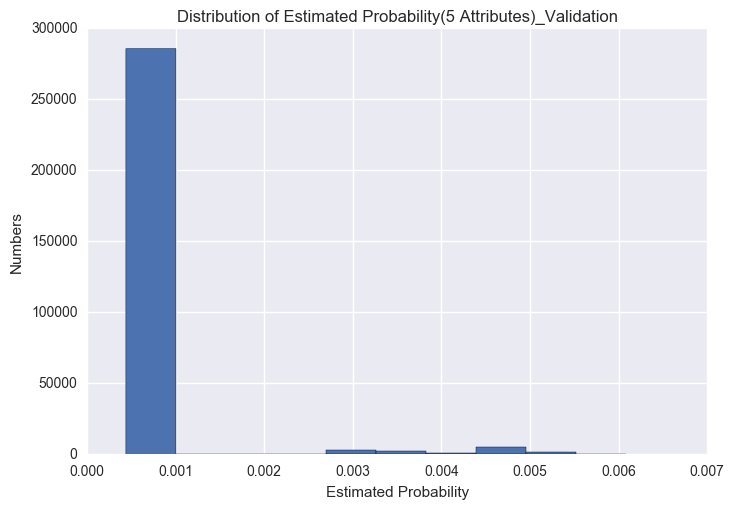

In [60]:
plt.xlabel('Estimated Probability')
plt.ylabel('Numbers')
va_df['log_prob'].hist()
#plt.yscale('log')
plt.title("Distribution of Estimated Probability(5 Attributes)_Validation")
plt.legend()
plt.show()

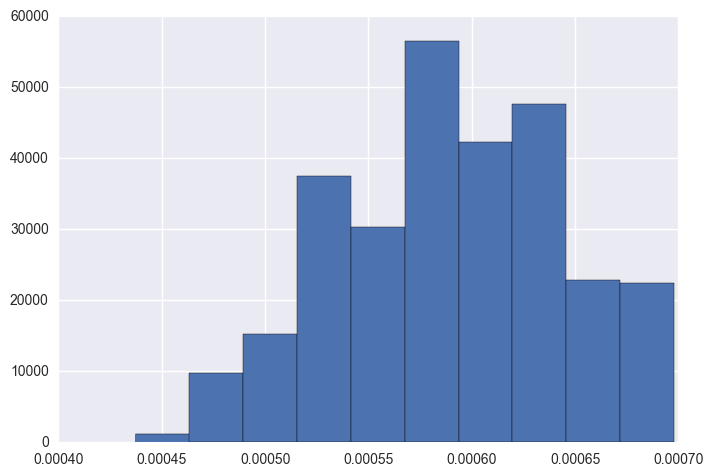

In [61]:
va_df_small = va_df[va_df['log_prob'] < 0.001]
va_df_small['log_prob'].hist()
plt.show()

In [62]:
print(va_df['log_prob'].describe())

count    299745.000000
mean          0.000755
std           0.000770
min           0.000437
25%           0.000551
50%           0.000593
75%           0.000637
max           0.006086
Name: log_prob, dtype: float64


In [63]:
f = interpolate.interp1d( [min(va_df['log_prob']) , max(va_df['log_prob'])], [min(va_df['payprice']), max(va_df['payprice']) ])
va_df['estimatedBidPrice'] = va_df['log_prob'].apply(  lambda x: f(x) )

E:\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


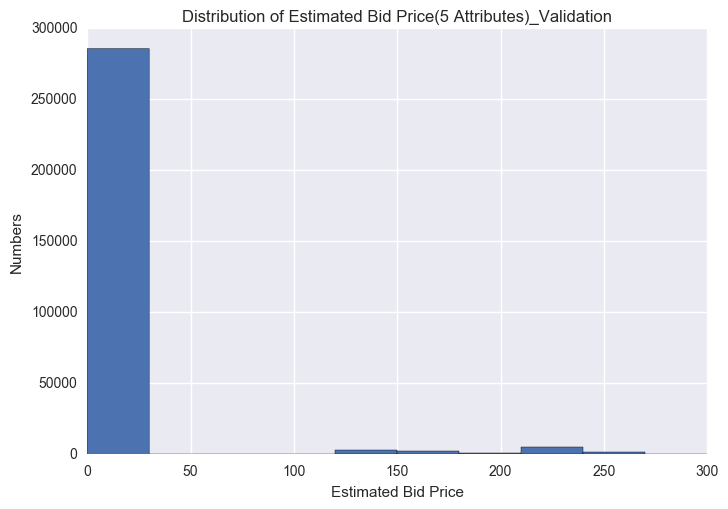

In [64]:
plt.xlabel('Estimated Bid Price')
plt.ylabel('Numbers')
va_df['estimatedBidPrice'].hist()
#plt.yscale('log')
plt.title("Distribution of Estimated Bid Price(5 Attributes)_Validation")
plt.legend()
plt.show()

In [65]:
# Information about bid price
print(va_df['estimatedBidPrice'].describe())
print("variance:", va_df['estimatedBidPrice'].var())
print("skewness:", st.skew(va_df['estimatedBidPrice'],bias=False)) 
print("kurtosis:", st.kurtosis(va_df['estimatedBidPrice'],bias=False)) 

count    299745.000000
mean         16.883990
std          40.893155
min           0.000000
25%           6.024578
50%           8.263049
75%          10.618899
max         300.000000
Name: estimatedBidPrice, dtype: float64
variance: 1672.250142600918
skewness: 4.661142970307628
kurtosis: 20.882837843963674


In [66]:
# Information about pay price
print(va_df['payprice'].describe())
print("variance:", va_df['payprice'].var())
print("skewness:", st.skew(va_df['payprice'],bias=False))
print("kurtosis:", st.kurtosis(va_df['payprice'],bias=False))

count    299745.000000
mean         80.217765
std          62.365778
min           0.000000
25%          33.000000
50%          70.000000
75%         101.000000
max         300.000000
Name: payprice, dtype: float64
variance: 3889.490303729888
skewness: 1.2558899702835147
kurtosis: 1.0928950971859432


E:\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


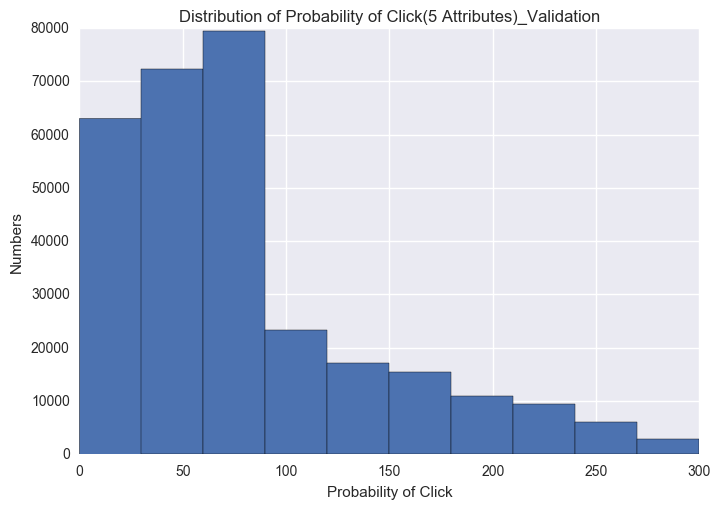

In [67]:
plt.xlabel('Probability of Click')
plt.ylabel('Numbers')
va_df['payprice'].hist()
#plt.yscale('log')
plt.title("Distribution of Probability of Click(5 Attributes)_Validation")
plt.legend()
plt.show()

In [68]:
f = interpolate.interp1d( [min(va_df['log_prob']) , max(va_df['log_prob'])], [min(va_df['payprice']), max(va_df['payprice']) ])
va_df['estimatedBidPrice_x2.5'] = va_df['log_prob'].apply(  lambda x: f(x)*2.5 )

E:\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


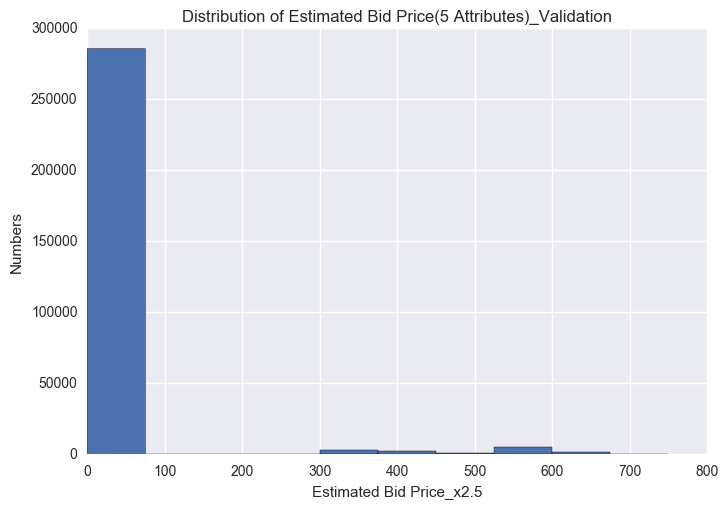

In [69]:
plt.xlabel('Estimated Bid Price_x2.5')
plt.ylabel('Numbers')
va_df['estimatedBidPrice_x2.5'].hist()
#plt.yscale('log')
plt.title("Distribution of Estimated Bid Price(5 Attributes)_Validation")
plt.legend()
plt.show()

#### Tables

In [70]:
impression = va_df[va_df['estimatedBidPrice'] > va_df['payprice']]
click = impression[impression['click'] == 1 ]

impression_x2 = va_df[va_df['estimatedBidPrice_x2.5'] > va_df['payprice']]
click_x2 = impression_x2[impression_x2['click'] == 1 ]

In [71]:
## Deleting 25% from df['estimatedBidPrice_x2.5']
impression_d25 = va_df[(va_df['estimatedBidPrice_x2.5'] > va_df['payprice']) & (va_df['log_prob'] > va_df['log_prob'].quantile(0.25) )]
click_d25 = impression_d25[impression_d25['click'] == 1 ]

In [72]:
## Deleting 50% from df['estimatedBidPrice_x2.5']
impression_d50 = va_df[(va_df['estimatedBidPrice_x2.5'] > va_df['payprice']) & (va_df['log_prob'] > va_df['log_prob'].quantile(0.5) )]
click_d50 = impression_d50[impression_d50['click'] == 1 ]

In [73]:
f = interpolate.interp1d( [min(va_df['log_prob']) , max(va_df['log_prob'])], [min(va_df['payprice']), max(va_df['payprice']) ])
va_df['estimatedBidPrice_x4'] = va_df['log_prob'].apply(  lambda x: f(x)*4 )

In [74]:
impression_x4 = va_df[va_df['estimatedBidPrice_x4'] > va_df['payprice']]
click_x4 = impression_x4[impression_x4['click'] == 1 ]

In [75]:
va_df.click.value_counts()
df.payprice.median()

70.0

In [76]:
df_click1 = df[df['click'] ==1]
df.click.value_counts()

0    2695612
1       2034
Name: click, dtype: int64

In [77]:
df_click1.payprice.median()

84.0

In [78]:
va_df['estimatedBidPrice_linear'] = va_df['log_prob'] * 84.0 /(2034/(2034+2695612))

In [79]:
impression_linear = va_df[va_df['estimatedBidPrice_linear'] > va_df['payprice']]
click_linear = impression_linear[impression_linear['click'] == 1 ]

In [80]:
va_df['estimatedBidPrice_linear_70'] = va_df['log_prob'] * 70.0 /(2034/(2034+2695612))
impression_linear_70 = va_df[va_df['estimatedBidPrice_linear_70'] > va_df['payprice']]
click_linear_70 = impression_linear_70[impression_linear_70['click'] == 1 ]

In [81]:
x = PrettyTable(["Variable", "Impression", 'Click', 'CTR'])
x.align["Impression"] = "1" # Left align city names 
x.padding_width = 0 # One space between column edges and contents (default)

x.add_row(["estimatedBidPrice", impression.shape[0], \
           click.shape[0], \
           click.shape[0]/impression.shape[0]])

x.add_row(["estimatedBidPrice_x2.5", impression_x2.shape[0], \
           click_x2.shape[0], \
           click_x2.shape[0]/impression_x2.shape[0]])

x.add_row(["estimatedBidPrice_x2.5_d25", impression_d25.shape[0], \
           click_d25.shape[0], \
           click_d25.shape[0]/impression_d25.shape[0]])

x.add_row(["estimatedBidPrice_x2.5_d50", impression_d50.shape[0], \
           click_d50.shape[0], \
           click_d50.shape[0]/impression_d50.shape[0]])

x.add_row(["estimatedBidPrice_x4", impression_x4.shape[0], \
           click_x4.shape[0], \
           click_x4.shape[0]/impression_x4.shape[0]])

x.add_row(["estimatedBidPrice_linear", impression_linear.shape[0], \
           click_linear.shape[0], \
           click_linear.shape[0]/impression_linear.shape[0]])

x.add_row(["estimatedBidPrice_linear_70", impression_linear_70.shape[0], \
           click_linear_70.shape[0], \
           click_linear_70.shape[0]/impression_linear_70.shape[0]])

print(x)

+---------------------------+----------+-----+---------------------+
|          Variable         |Impression|Click|         CTR         |
+---------------------------+----------+-----+---------------------+
|     estimatedBidPrice     |  22170   |  52 | 0.002345511953089761|
|   estimatedBidPrice_x2.5  |  52651   |  65 |0.0012345444530968072|
| estimatedBidPrice_x2.5_d25|  47874   |  65 |0.0013577307097798388|
| estimatedBidPrice_x2.5_d50|  40463   |  63 | 0.001556977979882856|
|    estimatedBidPrice_x4   |  76527   |  71 |0.0009277771244136057|
|  estimatedBidPrice_linear |  157436  | 108 |0.0006859930384410173|
|estimatedBidPrice_linear_70|  129517  |  91 |0.0007026104681238756|
+---------------------------+----------+-----+---------------------+


In [82]:
pd.DataFrame(narray).to_csv('narray.csv', encoding='utf-8')
pd.DataFrame(probarray).to_csv('probarray.csv', encoding='utf-8')

## Training Logistic Regression (linear_model.LogisticRegressionCV)

In [83]:
# Defining X and Y
X = df[[col for col in df.columns if col not in ['click', 'payprice', 'bidprice']]]
Y = df['click']

In [84]:
# Training the model
logregCV = linear_model.LogisticRegressionCV()

In [85]:
logregCV.fit(X, Y)

LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

In [86]:
logregCV.score(X_validation, Y_validation)

0.99924602578858701

In [87]:
logregCV.predict_proba(X_validation)

array([[  9.99249287e-01,   7.50713175e-04],
       [  9.99180258e-01,   8.19742120e-04],
       [  9.99265695e-01,   7.34305153e-04],
       ..., 
       [  9.99225181e-01,   7.74818785e-04],
       [  9.99253605e-01,   7.46395375e-04],
       [  9.99228084e-01,   7.71916480e-04]])

In [88]:
va_df.drop(['log_prob', 'estimatedBidPrice', 'estimatedBidPrice_x2.5', 'estimatedBidPrice_x4', \
            'estimatedBidPrice_linear', 'estimatedBidPrice_linear_70'], axis=1, inplace=True)

In [89]:
probarray = logregCV.predict_proba(va_df[[col for col in va_df.columns if col not in ['click', 'payprice', 'bidprice']]])
va_df['log_prob'] =probarray[:,1]
probarray

array([[  9.99249287e-01,   7.50713175e-04],
       [  9.99180258e-01,   8.19742120e-04],
       [  9.99265695e-01,   7.34305153e-04],
       ..., 
       [  9.99225181e-01,   7.74818785e-04],
       [  9.99253605e-01,   7.46395375e-04],
       [  9.99228084e-01,   7.71916480e-04]])

E:\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


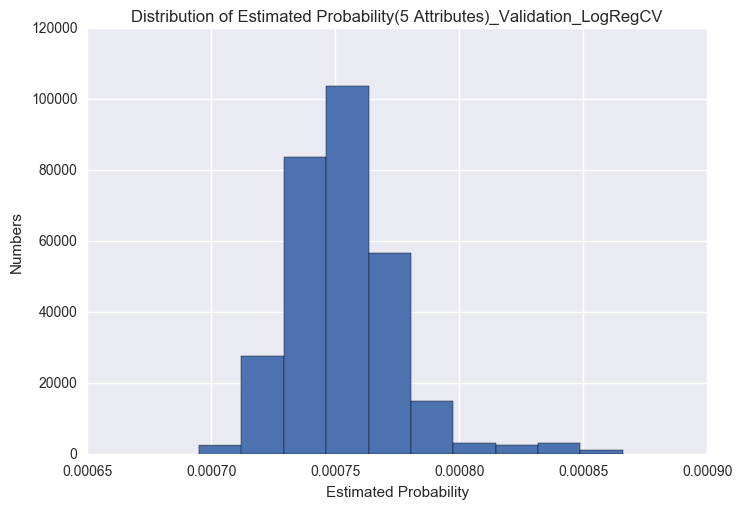

In [90]:
plt.xlabel('Estimated Probability')
plt.ylabel('Numbers')
va_df['log_prob'].hist()
#plt.yscale('log')
plt.title("Distribution of Estimated Probability(5 Attributes)_Validation_LogRegCV")
plt.legend()
plt.show()

count    299745.000000
mean          0.000754
std           0.000022
min           0.000695
25%           0.000740
50%           0.000752
75%           0.000765
max           0.000866
Name: log_prob, dtype: float64


E:\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


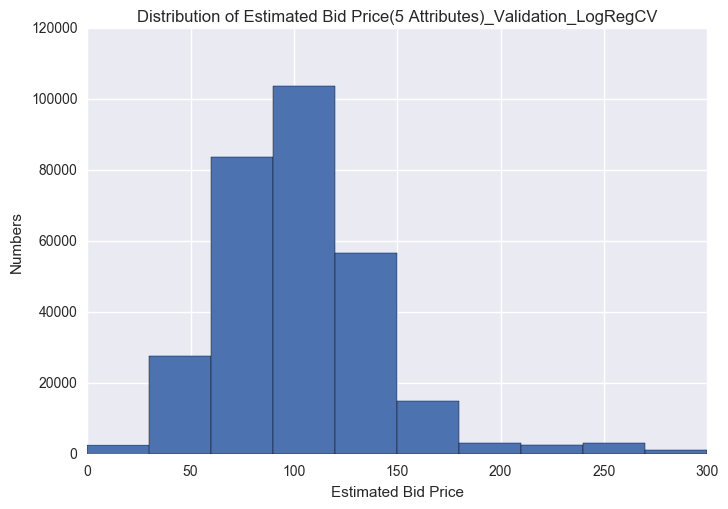

In [91]:
print(va_df['log_prob'].describe())
f = interpolate.interp1d( [min(va_df['log_prob']) , max(va_df['log_prob'])], [min(va_df['payprice']), max(va_df['payprice']) ])
va_df['estimatedBidPrice'] = va_df['log_prob'].apply(  lambda x: f(x) )
plt.xlabel('Estimated Bid Price')
plt.ylabel('Numbers')
va_df['estimatedBidPrice'].hist()
#plt.yscale('log')
plt.title("Distribution of Estimated Bid Price(5 Attributes)_Validation_LogRegCV")
plt.legend()
plt.show()

In [92]:
# Information about bid price
print(va_df['estimatedBidPrice'].describe())
print("variance:", va_df['estimatedBidPrice'].var())
print("skewness:", st.skew(va_df['estimatedBidPrice'],bias=False)) 
print("kurtosis:", st.kurtosis(va_df['estimatedBidPrice'],bias=False)) 

count    299745.000000
mean        103.249514
std          38.757912
min           0.000000
25%          78.799849
50%         100.155212
75%         121.871351
max         300.000000
Name: estimatedBidPrice, dtype: float64
variance: 1502.1757583441406
skewness: 1.2366492394411779
kurtosis: 3.5651769300542355


In [93]:
# Information about pay price
print(va_df['payprice'].describe())
print("variance:", va_df['payprice'].var())
print("skewness:", st.skew(va_df['payprice'],bias=False))
print("kurtosis:", st.kurtosis(va_df['payprice'],bias=False))

count    299745.000000
mean         80.217765
std          62.365778
min           0.000000
25%          33.000000
50%          70.000000
75%         101.000000
max         300.000000
Name: payprice, dtype: float64
variance: 3889.490303729888
skewness: 1.2558899702835147
kurtosis: 1.0928950971859432


E:\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


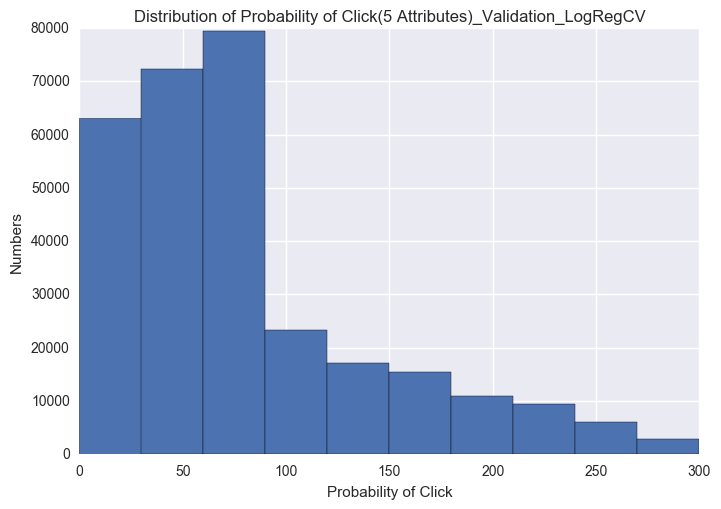

In [94]:
plt.xlabel('Probability of Click')
plt.ylabel('Numbers')
va_df['payprice'].hist()
#plt.yscale('log')
plt.title("Distribution of Probability of Click(5 Attributes)_Validation_LogRegCV")
plt.legend()
plt.show()

In [95]:
f = interpolate.interp1d( [min(va_df['log_prob']) , max(va_df['log_prob'])], [min(va_df['payprice']), max(va_df['payprice']) ])
va_df['estimatedBidPrice_x2.5'] = va_df['log_prob'].apply(  lambda x: f(x)*2.5 )

E:\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


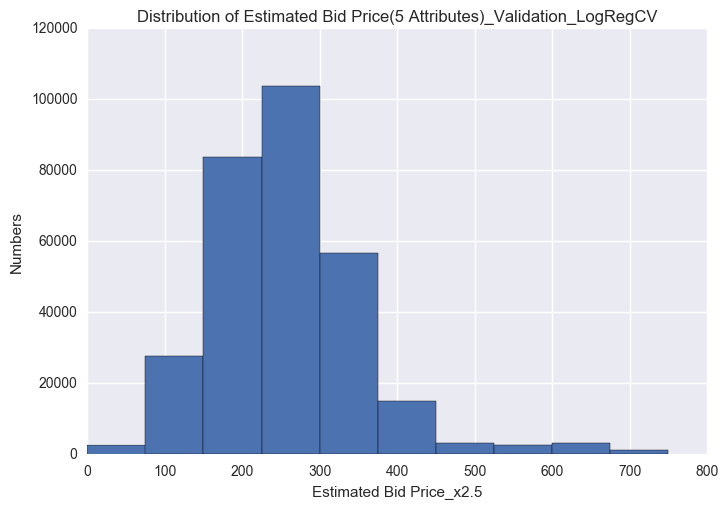

In [96]:
plt.xlabel('Estimated Bid Price_x2.5')
plt.ylabel('Numbers')
va_df['estimatedBidPrice_x2.5'].hist()
#plt.yscale('log')
plt.title("Distribution of Estimated Bid Price(5 Attributes)_Validation_LogRegCV")
plt.legend()
plt.show()

### Tables

In [97]:
impression = va_df[va_df['estimatedBidPrice'] > va_df['payprice']]
click = impression[impression['click'] == 1 ]

impression_x2 = va_df[va_df['estimatedBidPrice_x2.5'] > va_df['payprice']]
click_x2 = impression_x2[impression_x2['click'] == 1 ]

## Deleting 25% from df['estimatedBidPrice_x2.5']
impression_d25 = va_df[(va_df['estimatedBidPrice_x2.5'] > va_df['payprice']) & (va_df['log_prob'] > va_df['log_prob'].quantile(0.25) )]
click_d25 = impression_d25[impression_d25['click'] == 1 ]

## Deleting 50% from df['estimatedBidPrice_x2.5']
impression_d50 = va_df[(va_df['estimatedBidPrice_x2.5'] > va_df['payprice']) & (va_df['log_prob'] > va_df['log_prob'].quantile(0.5) )]
click_d50 = impression_d50[impression_d50['click'] == 1 ]

f = interpolate.interp1d( [min(va_df['log_prob']) , max(va_df['log_prob'])], [min(va_df['payprice']), max(va_df['payprice']) ])
va_df['estimatedBidPrice_x4'] = va_df['log_prob'].apply(  lambda x: f(x)*4 )

impression_x4 = va_df[va_df['estimatedBidPrice_x4'] > va_df['payprice']]
click_x4 = impression_x4[impression_x4['click'] == 1 ]

va_df['estimatedBidPrice_linear'] = va_df['log_prob'] * 84.0 /(2034/(2034+2695612))

impression_linear = va_df[va_df['estimatedBidPrice_linear'] > va_df['payprice']]
click_linear = impression_linear[impression_linear['click'] == 1 ]

va_df['estimatedBidPrice_linear_70'] = va_df['log_prob'] * 70.0 /(2034/(2034+2695612))
impression_linear_70 = va_df[va_df['estimatedBidPrice_linear_70'] > va_df['payprice']]
click_linear_70 = impression_linear_70[impression_linear_70['click'] == 1 ]

In [98]:
x = PrettyTable(["Variable", "Impression", 'Click', 'CTR'])
x.align["Impression"] = "1" # Left align city names 
x.padding_width = 0 # One space between column edges and contents (default)

x.add_row(["estimatedBidPrice", impression.shape[0], \
           click.shape[0], \
           click.shape[0]/impression.shape[0]])

x.add_row(["estimatedBidPrice_x2.5", impression_x2.shape[0], \
           click_x2.shape[0], \
           click_x2.shape[0]/impression_x2.shape[0]])

x.add_row(["estimatedBidPrice_x2.5_d25", impression_d25.shape[0], \
           click_d25.shape[0], \
           click_d25.shape[0]/impression_d25.shape[0]])

x.add_row(["estimatedBidPrice_x2.5_d50", impression_d50.shape[0], \
           click_d50.shape[0], \
           click_d50.shape[0]/impression_d50.shape[0]])

x.add_row(["estimatedBidPrice_x4", impression_x4.shape[0], \
           click_x4.shape[0], \
           click_x4.shape[0]/impression_x4.shape[0]])

x.add_row(["estimatedBidPrice_linear", impression_linear.shape[0], \
           click_linear.shape[0], \
           click_linear.shape[0]/impression_linear.shape[0]])

x.add_row(["estimatedBidPrice_linear_70", impression_linear_70.shape[0], \
           click_linear_70.shape[0], \
           click_linear_70.shape[0]/impression_linear_70.shape[0]])

print(x)

+---------------------------+----------+-----+---------------------+
|          Variable         |Impression|Click|         CTR         |
+---------------------------+----------+-----+---------------------+
|     estimatedBidPrice     |  205287  | 139 | 0.000677100839312767|
|   estimatedBidPrice_x2.5  |  286418  | 212 |0.0007401769441864688|
| estimatedBidPrice_x2.5_d25|  220618  | 182 |0.0008249553526910769|
| estimatedBidPrice_x2.5_d50|  149060  | 133 |0.0008922581510801019|
|    estimatedBidPrice_x4   |  297163  | 224 |0.0007537950552390439|
|  estimatedBidPrice_linear |  201547  | 109 |0.0005408167821897622|
|estimatedBidPrice_linear_70|  154823  |  63 |0.0004069162850480872|
+---------------------------+----------+-----+---------------------+


## Training Logistic Regression (linear_model.SGDClassifier(loss='log'))

In [99]:
# Defining X and Y
X = df[[col for col in df.columns if col not in ['click', 'payprice', 'bidprice']]]
Y = df['click']

In [100]:
# Training the model
SGDlog = linear_model.SGDClassifier(loss='log')

In [101]:
SGDlog.fit(X, Y)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)

In [102]:
SGDlog.score(X_validation, Y_validation)

0.99924602578858701

In [103]:
SGDlog.predict_proba(X_validation)

array([[  9.99395975e-01,   6.04025155e-04],
       [  9.97551131e-01,   2.44886876e-03],
       [  9.99423764e-01,   5.76235919e-04],
       ..., 
       [  9.99281523e-01,   7.18477321e-04],
       [  9.99406652e-01,   5.93347845e-04],
       [  9.99313958e-01,   6.86042439e-04]])

In [104]:
va_df.drop(['log_prob', 'estimatedBidPrice', 'estimatedBidPrice_x2.5', 'estimatedBidPrice_x4', \
            'estimatedBidPrice_linear', 'estimatedBidPrice_linear_70'], axis=1, inplace=True)

In [105]:
probarray = logregCV.predict_proba(va_df[[col for col in va_df.columns if col not in ['click', 'payprice', 'bidprice']]])
va_df['log_prob'] =probarray[:,1]
probarray

array([[  9.99249287e-01,   7.50713175e-04],
       [  9.99180258e-01,   8.19742120e-04],
       [  9.99265695e-01,   7.34305153e-04],
       ..., 
       [  9.99225181e-01,   7.74818785e-04],
       [  9.99253605e-01,   7.46395375e-04],
       [  9.99228084e-01,   7.71916480e-04]])

count    299745.000000
mean          0.000754
std           0.000022
min           0.000695
25%           0.000740
50%           0.000752
75%           0.000765
max           0.000866
Name: log_prob, dtype: float64


E:\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


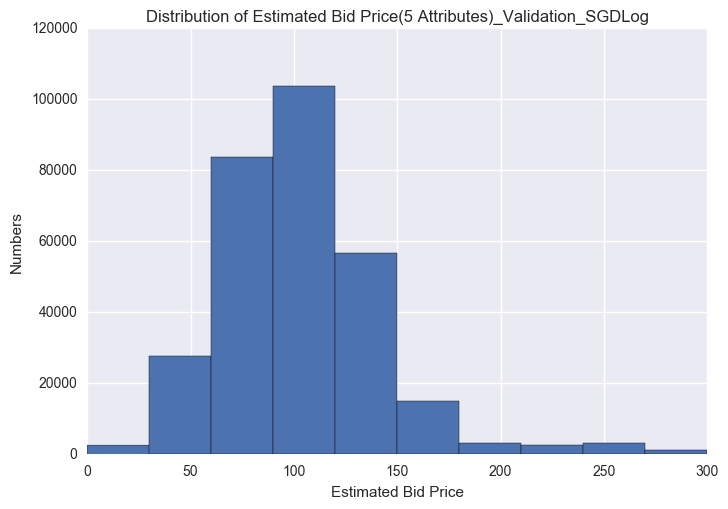

In [106]:
print(va_df['log_prob'].describe())
f = interpolate.interp1d( [min(va_df['log_prob']) , max(va_df['log_prob'])], [min(va_df['payprice']), max(va_df['payprice']) ])
va_df['estimatedBidPrice'] = va_df['log_prob'].apply(  lambda x: f(x) )
plt.xlabel('Estimated Bid Price')
plt.ylabel('Numbers')
va_df['estimatedBidPrice'].hist()
#plt.yscale('log')
plt.title("Distribution of Estimated Bid Price(5 Attributes)_Validation_SGDLog")
plt.legend()
plt.show()

In [107]:
# Information about bid price
print(va_df['estimatedBidPrice'].describe())
print("variance:", va_df['estimatedBidPrice'].var())
print("skewness:", st.skew(va_df['estimatedBidPrice'],bias=False)) 
print("kurtosis:", st.kurtosis(va_df['estimatedBidPrice'],bias=False)) 

count    299745.000000
mean        103.249514
std          38.757912
min           0.000000
25%          78.799849
50%         100.155212
75%         121.871351
max         300.000000
Name: estimatedBidPrice, dtype: float64
variance: 1502.1757583441406
skewness: 1.2366492394411779
kurtosis: 3.5651769300542355


In [108]:
# Information about pay price
print(va_df['payprice'].describe())
print("variance:", va_df['payprice'].var())
print("skewness:", st.skew(va_df['payprice'],bias=False))
print("kurtosis:", st.kurtosis(va_df['payprice'],bias=False))

count    299745.000000
mean         80.217765
std          62.365778
min           0.000000
25%          33.000000
50%          70.000000
75%         101.000000
max         300.000000
Name: payprice, dtype: float64
variance: 3889.490303729888
skewness: 1.2558899702835147
kurtosis: 1.0928950971859432


E:\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


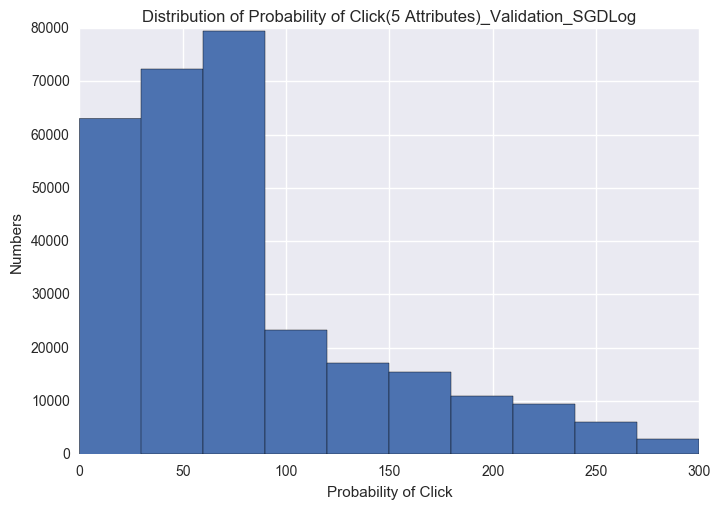

In [109]:
plt.xlabel('Probability of Click')
plt.ylabel('Numbers')
va_df['payprice'].hist()
#plt.yscale('log')
plt.title("Distribution of Probability of Click(5 Attributes)_Validation_SGDLog")
plt.legend()
plt.show()

In [110]:
f = interpolate.interp1d( [min(va_df['log_prob']) , max(va_df['log_prob'])], [min(va_df['payprice']), max(va_df['payprice']) ])
va_df['estimatedBidPrice_x2.5'] = va_df['log_prob'].apply(  lambda x: f(x)*2.5 )

E:\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


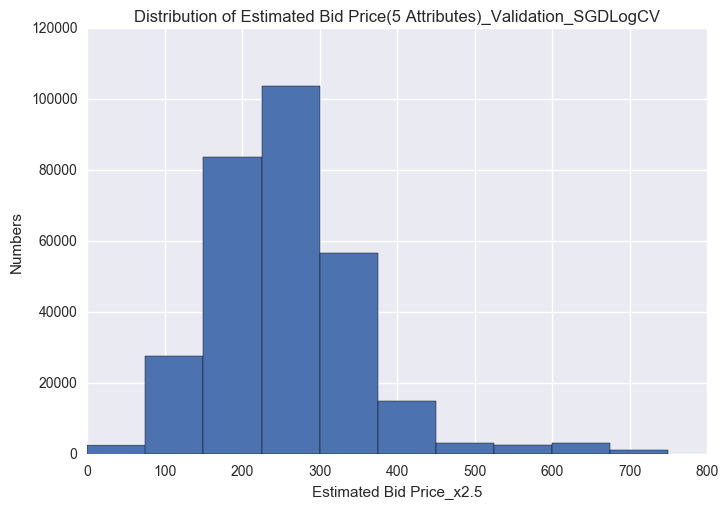

In [111]:
plt.xlabel('Estimated Bid Price_x2.5')
plt.ylabel('Numbers')
va_df['estimatedBidPrice_x2.5'].hist()
#plt.yscale('log')
plt.title("Distribution of Estimated Bid Price(5 Attributes)_Validation_SGDLogCV")
plt.legend()
plt.show()

### Table

In [132]:
impression = va_df[va_df['estimatedBidPrice'] > va_df['payprice']]
click = impression[impression['click'] == 1 ]

impression_x2 = va_df[va_df['estimatedBidPrice_x2.5'] > va_df['payprice']]
click_x2 = impression_x2[impression_x2['click'] == 1 ]

## Deleting 25% from df['estimatedBidPrice_x2.5']
impression_d25 = va_df[(va_df['estimatedBidPrice_x2.5'] > va_df['payprice']) & (va_df['log_prob'] > va_df['log_prob'].quantile(0.25) )]
click_d25 = impression_d25[impression_d25['click'] == 1 ]

## Deleting 50% from df['estimatedBidPrice_x2.5']
impression_d50 = va_df[(va_df['estimatedBidPrice_x2.5'] > va_df['payprice']) & (va_df['log_prob'] > va_df['log_prob'].quantile(0.5) )]
click_d50 = impression_d50[impression_d50['click'] == 1 ]

f = interpolate.interp1d( [min(va_df['log_prob']) , max(va_df['log_prob'])], [min(va_df['payprice']), max(va_df['payprice']) ])
va_df['estimatedBidPrice_x4'] = va_df['log_prob'].apply(  lambda x: f(x)*4 )

impression_x4 = va_df[va_df['estimatedBidPrice_x4'] > va_df['payprice']]
click_x4 = impression_x4[impression_x4['click'] == 1 ]

va_df['estimatedBidPrice_linear'] = va_df['log_prob'] * 84.0 /(2034/(2034+2695612))

impression_linear = va_df[va_df['estimatedBidPrice_linear'] > va_df['payprice']]
click_linear = impression_linear[impression_linear['click'] == 1 ]

va_df['estimatedBidPrice_linear_70'] = va_df['log_prob'] * 70.0 /(2034/(2034+2695612))
impression_linear_70 = va_df[va_df['estimatedBidPrice_linear_70'] > va_df['payprice']]
click_linear_70 = impression_linear_70[impression_linear_70['click'] == 1 ]

In [133]:
x = PrettyTable(["Variable", "Impression", 'Click', 'CTR'])
x.align["Impression"] = "1" # Left align city names 
x.padding_width = 0 # One space between column edges and contents (default)

x.add_row(["estimatedBidPrice", impression.shape[0], \
           click.shape[0], \
           click.shape[0]/impression.shape[0]])

x.add_row(["estimatedBidPrice_x2.5", impression_x2.shape[0], \
           click_x2.shape[0], \
           click_x2.shape[0]/impression_x2.shape[0]])

x.add_row(["estimatedBidPrice_x2.5_d25", impression_d25.shape[0], \
           click_d25.shape[0], \
           click_d25.shape[0]/impression_d25.shape[0]])

x.add_row(["estimatedBidPrice_x2.5_d50", impression_d50.shape[0], \
           click_d50.shape[0], \
           click_d50.shape[0]/impression_d50.shape[0]])

x.add_row(["estimatedBidPrice_x4", impression_x4.shape[0], \
           click_x4.shape[0], \
           click_x4.shape[0]/impression_x4.shape[0]])

x.add_row(["estimatedBidPrice_linear", impression_linear.shape[0], \
           click_linear.shape[0], \
           click_linear.shape[0]/impression_linear.shape[0]])

x.add_row(["estimatedBidPrice_linear_70", impression_linear_70.shape[0], \
           click_linear_70.shape[0], \
           click_linear_70.shape[0]/impression_linear_70.shape[0]])

print(x)

+---------------------------+----------+-----+---------------------+
|          Variable         |Impression|Click|         CTR         |
+---------------------------+----------+-----+---------------------+
|     estimatedBidPrice     |  205287  | 139 | 0.000677100839312767|
|   estimatedBidPrice_x2.5  |  286418  | 212 |0.0007401769441864688|
| estimatedBidPrice_x2.5_d25|  220618  | 182 |0.0008249553526910769|
| estimatedBidPrice_x2.5_d50|  149060  | 133 |0.0008922581510801019|
|    estimatedBidPrice_x4   |  297163  | 224 |0.0007537950552390439|
|  estimatedBidPrice_linear |  201547  | 109 |0.0005408167821897622|
|estimatedBidPrice_linear_70|  154823  |  63 |0.0004069162850480872|
+---------------------------+----------+-----+---------------------+


In [127]:
impression_d65 = va_df[(va_df['estimatedBidPrice_x2.5'] > va_df['payprice']) & (va_df['log_prob'] > va_df['log_prob'].quantile(0.65) )]
click_d65 = impression_d65[impression_d65['click'] == 1 ]

impression_d70 = va_df[(va_df['estimatedBidPrice_x2.5'] > va_df['payprice']) & (va_df['log_prob'] > va_df['log_prob'].quantile(0.7) )]
click_d70 = impression_d70[impression_d70['click'] == 1 ]

impression_d71_5 = va_df[(va_df['estimatedBidPrice_x2.5'] > va_df['payprice']) & (va_df['log_prob'] > va_df['log_prob'].quantile(0.715) )]
click_d71_5 = impression_d71_5[impression_d71_5['click'] == 1 ]

impression_d75 = va_df[(va_df['estimatedBidPrice_x2.5'] > va_df['payprice']) & (va_df['log_prob'] > va_df['log_prob'].quantile(0.75) )]
click_d75 = impression_d75[impression_d75['click'] == 1 ]

y = PrettyTable(["Variable", "Impression", 'Click', 'CTR'])
y.align["Impression"] = "1" # Left align city names 
y.padding_width = 0 # One space between column edges and contents (default)

y.add_row(["estimatedBidPrice_x2.5_d65", impression_d65.shape[0], \
           click_d65.shape[0], \
           click_d65.shape[0]/impression_d65.shape[0]])

y.add_row(["estimatedBidPrice_x2.5_d70", impression_d70.shape[0], \
           click_d70.shape[0], \
           click_d70.shape[0]/impression_d70.shape[0]])

y.add_row(["estimatedBidPrice_x2.5_d71_5", impression_d71_5.shape[0], \
           click_d71_5.shape[0], \
           click_d71_5.shape[0]/impression_d71_5.shape[0]])

y.add_row(["estimatedBidPrice_x2.5_d75", impression_d75.shape[0], \
           click_d75.shape[0], \
           click_d75.shape[0]/impression_d75.shape[0]])

print(y)

+----------------------------+----------+-----+---------------------+
|          Variable          |Impression|Click|         CTR         |
+----------------------------+----------+-----+---------------------+
| estimatedBidPrice_x2.5_d65 |  104744  | 112 |0.0010692736576796763|
| estimatedBidPrice_x2.5_d70 |  90050   | 104 |0.0011549139367018322|
|estimatedBidPrice_x2.5_d71_5|  85291   | 101 |0.0011841812148995791|
| estimatedBidPrice_x2.5_d75 |  74724   |  95 |0.0012713452170654675|
+----------------------------+----------+-----+---------------------+


In [142]:
va_df.log_prob.quantile(q=0.25)

0.00073997975287428536

In [143]:
log_prob_list = va_df['log_prob'].tolist()
va_df.log_prob.describe()

count    299745.000000
mean          0.000754
std           0.000022
min           0.000695
25%           0.000740
50%           0.000752
75%           0.000765
max           0.000866
Name: log_prob, dtype: float64

In [148]:
for i in range(len(log_prob_list)):
    if log_prob_list[i] > 0.000765:
    # if log_prob_list[i] > va_df.log_prob.quantile(0.75): 
        log_prob_list[i] *= 2.5
    elif log_prob_list[i] > 0.000752:
    # elif log_prob_list[i] > va_df.log_prob.quantile(0.5):
        log_prob_list[i] *=1.5

va_df['log_prob_nonlinear'] = pd.DataFrame(log_prob_list)

In [149]:
f = interpolate.interp1d( [min(va_df['log_prob_nonlinear']) , max(va_df['log_prob_nonlinear'])], \
                          [min(va_df['payprice']), max(va_df['payprice']) ])
va_df['estimatedBidPrice_nonlinear'] = va_df['log_prob_nonlinear'].apply(  lambda x: f(x) )

impression_nonlinear = va_df[va_df['estimatedBidPrice_nonlinear'] > va_df['payprice']]
click_nonlinear = impression_nonlinear[impression_nonlinear['click'] == 1 ]

z = PrettyTable(["Variable", "Impression", 'Click', 'CTR'])
z.align["Impression"] = "1" # Left align city names 
z.padding_width = 0 # One space between column edges and contents (default)

z.add_row(["estimatedBidPrice_nonlinear", impression_nonlinear.shape[0], \
           click_nonlinear.shape[0], \
           click_nonlinear.shape[0]/impression_nonlinear.shape[0]])

print(z)

+---------------------------+----------+-----+---------------------+
|          Variable         |Impression|Click|         CTR         |
+---------------------------+----------+-----+---------------------+
|estimatedBidPrice_nonlinear|  140138  |  99 |0.0007064465027330203|
+---------------------------+----------+-----+---------------------+


## Lasso

In [116]:
clf = linear_model.Lasso(alpha = 0.1)

In [117]:
clf.fit(X, Y)

Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [118]:
clf.score(X_validation, Y_validation)

-3.6060043839825084e-13

## XGBoost